In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [47]:
class HeatEquationPINN(nn.Module):
    def __init__(self, layers):
        super(HeatEquationPINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.epoch = 0
            
    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        for layer in self.layers[:-1]:
            xt = torch.tanh(layer(xt))
        return self.layers[-1](xt)
    
    def pde_loss(self, x_colloc, t_colloc):
        # Create variables that require gradients
        x = x_colloc.clone().requires_grad_(True)
        t = t_colloc.clone().requires_grad_(True)
        
        u = self.forward(x, t)
        
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), 
                                 create_graph=True, retain_graph=True)[0]
        
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                                 create_graph=True, retain_graph=True)[0]
        
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), 
                                  create_graph=True, retain_graph=True)[0]
        
        pde_residual = u_t - u_xx
        
        return torch.mean(pde_residual**2)
    
    def boundary_loss(self, x_bc, t_bc, bc_values):
        u_bc = self.forward(x_bc, t_bc)
        return torch.mean((u_bc - bc_values)**2)
    
    def initial_loss(self, x_ic, t_ic, ic_values):
        u_ic = self.forward(x_ic, t_ic)
        return torch.mean((u_ic - ic_values)**2)

In [48]:
model = HeatEquationPINN([2, 50, 1])

x_min, x_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0

# Generate collocation points
n_x, n_t = 50, 50
x_colloc = torch.linspace(x_min, x_max, n_x, requires_grad=True).view(-1, 1)
t_colloc = torch.linspace(t_min, t_max, n_t, requires_grad=True).view(-1, 1)
X_colloc, T_colloc = torch.meshgrid(x_colloc.squeeze(), t_colloc.squeeze())
x_colloc_mesh = X_colloc.reshape(-1, 1)
t_colloc_mesh = T_colloc.reshape(-1, 1)

x_bc_0 = torch.zeros(n_t, 1)
x_bc_1 = torch.ones(n_t, 1)
t_bc = t_colloc.clone()
bc_values = torch.zeros_like(t_bc.repeat(2, 1))

x_ic = x_colloc.clone()
t_ic = torch.zeros_like(x_ic)
ic_values = torch.sin(torch.pi * x_ic)

lamda_bc = 1.0
lamda_ic = 1.0
adam_lr = 0.0001
adam_epochs = 10000

total_losses = []
bc_losses = []
ic_losses = []
pde_losses = []

# Training with Adam + L-BFGS
optimizer = optim.Adam(model.parameters(), lr=adam_lr)

for epoch in range(adam_epochs):
    optimizer.zero_grad()
    
    x_bc = torch.cat([x_bc_0, x_bc_1], dim=0)
    t_bc_repeated = t_bc.repeat(2, 1) 
    bc_loss_val = model.boundary_loss(x_bc, t_bc_repeated, bc_values)
    ic_loss_val = model.initial_loss(x_ic, t_ic, ic_values)
    pde_loss_val = model.pde_loss(x_colloc_mesh, t_colloc_mesh)
    total_loss = pde_loss_val + lamda_bc * bc_loss_val + lamda_ic * ic_loss_val
    model.epoch += 1
    
    if model.epoch % 10 == 0:
      pde_losses.append(pde_loss_val)
      bc_losses.append(bc_loss_val)
      ic_losses.append(ic_loss_val)
      total_losses.append(total_loss)
    
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    if model.epoch % 500 == 0:
        print(f"Epoch {model.epoch}: PDE Loss: {pde_loss_val.item():.6f}, BC Loss: {bc_loss_val.item():.6f}, IC Loss: {ic_loss_val.item():.6f}")

lbfgs_optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)

def closure():
    global ctr
    lbfgs_optimizer.zero_grad()
    
    pde_loss_val = model.pde_loss(x_colloc_mesh, t_colloc_mesh)
    x_bc = torch.cat([x_bc_0, x_bc_1], dim=0)
    t_bc_repeated = t_bc.repeat(2, 1)
    bc_loss_val = model.boundary_loss(x_bc, t_bc_repeated, bc_values)
    ic_loss_val = model.initial_loss(x_ic, t_ic, ic_values)
    
    total_loss = pde_loss_val + lamda_bc * bc_loss_val + lamda_ic * ic_loss_val
    total_loss.backward(retain_graph=True)
    model.epoch += 1

    print(f"Epoch {model.epoch}: PDE Loss: {pde_loss_val.item():.6f}, BC Loss: {bc_loss_val.item():.6f}, IC Loss: {ic_loss_val.item():.6f}")

    if model.epoch % 10 == 0:
      pde_losses.append(pde_loss_val)
      bc_losses.append(bc_loss_val)
      ic_losses.append(ic_loss_val)
      total_losses.append(total_loss)
      
    return total_loss

lbfgs_optimizer.step(closure)

Epoch 500: PDE Loss: 0.006872, BC Loss: 0.077987, IC Loss: 0.181217
Epoch 1000: PDE Loss: 0.008664, BC Loss: 0.067964, IC Loss: 0.152602
Epoch 1500: PDE Loss: 0.007402, BC Loss: 0.060749, IC Loss: 0.137501
Epoch 2000: PDE Loss: 0.006180, BC Loss: 0.054031, IC Loss: 0.123840
Epoch 2500: PDE Loss: 0.005911, BC Loss: 0.050082, IC Loss: 0.111493
Epoch 3000: PDE Loss: 0.005530, BC Loss: 0.048924, IC Loss: 0.102150
Epoch 3500: PDE Loss: 0.004783, BC Loss: 0.048807, IC Loss: 0.095801
Epoch 4000: PDE Loss: 0.004067, BC Loss: 0.048417, IC Loss: 0.091484
Epoch 4500: PDE Loss: 0.003488, BC Loss: 0.047182, IC Loss: 0.088256
Epoch 5000: PDE Loss: 0.003200, BC Loss: 0.044997, IC Loss: 0.085298
Epoch 5500: PDE Loss: 0.003395, BC Loss: 0.042076, IC Loss: 0.082116
Epoch 6000: PDE Loss: 0.004168, BC Loss: 0.038780, IC Loss: 0.078598
Epoch 6500: PDE Loss: 0.005186, BC Loss: 0.035441, IC Loss: 0.074895
Epoch 7000: PDE Loss: 0.005826, BC Loss: 0.032140, IC Loss: 0.071159
Epoch 7500: PDE Loss: 0.005890, BC 

tensor(0.0610, grad_fn=<AddBackward0>)

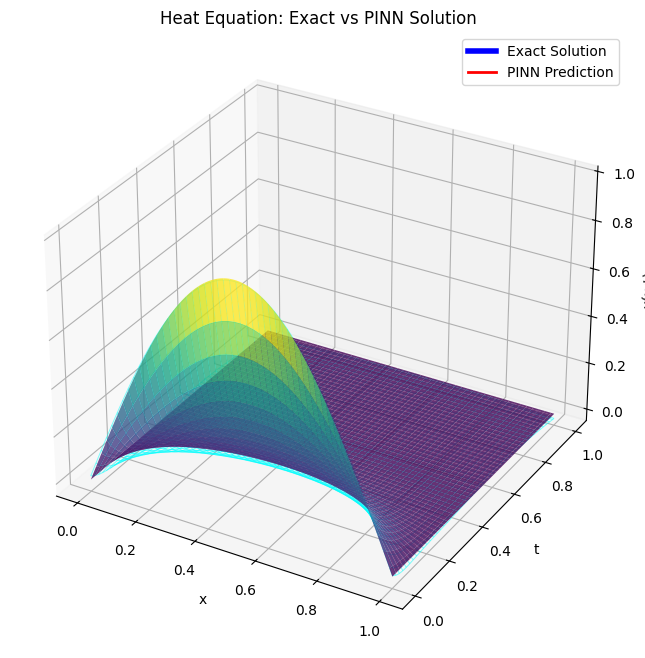

1050 1050


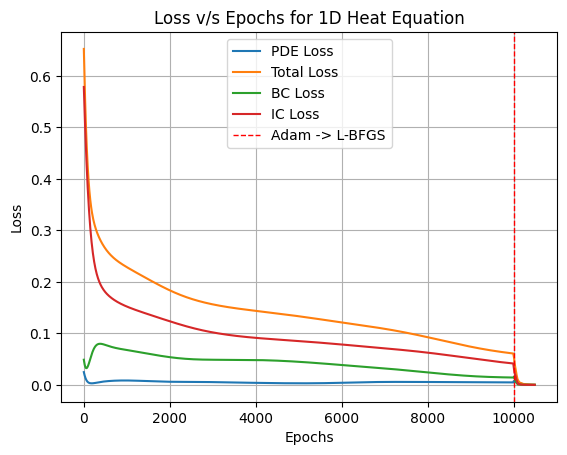

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 1, 100)  # Spatial domain [0, 1]
t = np.linspace(0, 1, 100)  # Time domain [0, 1]
X, T = np.meshgrid(x, t)

U_exact = np.exp(-np.pi**2 * T) * np.sin(np.pi * X)

U_pred = np.zeros((len(t), len(x)))
with torch.no_grad():
    for i, t_val in enumerate(t):
        t_tensor = torch.ones(len(x), 1) * t_val
        x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
        U_pred[i, :] = model(x_tensor, t_tensor).numpy().flatten()

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

surf_exact = ax.plot_surface(X, T, U_exact, cmap='viridis', alpha=0.8,
                           linewidth=0, antialiased=True)

surf_pred = ax.plot_wireframe(X, T, U_pred, color='cyan', linewidth=0.7, alpha=0.5)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Heat Equation: Exact vs PINN Solution')

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='blue', lw=4),
    Line2D([0], [0], color='red', lw=2)
]
ax.legend(custom_lines, ['Exact Solution', 'PINN Prediction'])

plt.show()

epochs = []
for x in range(model.epoch):
    if x % 10 == 0:
        epochs.append(x)

print(len(epochs), len(pde_losses))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epochs, [loss.detach().numpy() for loss in pde_losses], label='PDE Loss')
plt.plot(epochs, [loss.detach().numpy() for loss in total_losses], label='Total Loss')
plt.plot(epochs, [loss.detach().numpy() for loss in bc_losses], label='BC Loss')
plt.plot(epochs, [loss.detach().numpy() for loss in ic_losses], label='IC Loss')
plt.axvline(x=adam_epochs, color='r', linestyle='--', linewidth=1, label='Adam -> L-BFGS')
plt.grid(True)
plt.legend()
plt.title("Loss v/s Epochs for 1D Heat Equation")

plt.show()

In [ ]:
ctr

1